Loading data from kaggle

In [ ]:
!pip install --upgrade --force-reinstall  kaggle

In [ ]:
import os
user = ''
key = ''
 
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c osic-pulmonary-fibrosis-progression 
!kaggle datasets download -d sandorkonya/ct-lung-heart-trachea-segmentation

100% 13.3G/13.3G [03:38<00:00, 42.9MB/s]
100% 13.3G/13.3G [03:38<00:00, 65.6MB/s]
 76% 57.0M/75.4M [00:00<00:00, 44.2MB/s]
100% 75.4M/75.4M [00:00<00:00, 87.3MB/s]


In [ ]:
!unzip -q osic-pulmonary-fibrosis-progression.zip
!unzip -q ct-lung-heart-trachea-segmentation.zip
!rm -r osic-pulmonary-fibrosis-progression.zip
!rm -r ct-lung-heart-trachea-segmentation.zip

In [ ]:
!pip install pynrrd
!pip install pydicom

     |████████████████████████████████| 35.5MB 117kB/s 


In [ ]:
import os
import shutil
import re
import zipfile

import matplotlib.pyplot as plt
import cv2

import numpy as np
import pickle

import nrrd
import pydicom as pdm

from tqdm import tqdm

import io
import base64
from IPython.display import HTML


if not os.path.exists('/content/numpy_images_files/'):
    os.mkdir('/content/numpy_images_files/')

if not os.path.exists('/content/numpy_masks_files/'):
    os.mkdir('/content/numpy_masks_files/')

if not os.path.exists('/content/images/'):
    os.mkdir('/content/images/')

if not os.path.exists('/content/masks/'):
    os.mkdir('/content/masks/')

In [ ]:
class GlobalConfig:
    def __init__(self):
        self.root_path = '/content/'
        self.ocic_pfp_path = '/content/train/'
        self.ct_lht_path = 'content/ct-lung-heart-trachea-segmentation/'
        self.path_to_save_images_numpys = '/content/numpy_images_files/'
        self.path_to_save_masks_numpys = '/content/numpy_masks_files/'
        self.path_to_save_images = '/content/images/'
        self.path_to_save_masks = '/content/masks/'
        self.bad_ids = ['ID00011637202177653955184', 'ID00052637202186188008618']
        self.img_size = 512
    
config = GlobalConfig()

helpful functions

In [ ]:
def zip_and_remove(path: str):
    ziph = zipfile.ZipFile(f'{path}.zip', 'w', zipfile.ZIP_DEFLATED)
    
    for root, dirs, files in os.walk(path):
        for file in tqdm(files):
            file_path = os.path.join(root, file)
            ziph.write(file_path)
            os.remove(file_path)
    
    ziph.close()

Extraction all unique ids from file names

In [ ]:
def extract_file_ids(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".nrrd"):
                name_id = re.split('[/ _]', path)[-2]
                ids.append(name_id) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} ids.")
    return ids

In [ ]:
img_ids = os.listdir(config.ocic_pfp_path)
print(f"Extracted {len(img_ids)} ids.")
img_ids[:5]

Extracted 176 ids.


['ID00199637202248141386743',
 'ID00322637202284842245491',
 'ID00235637202261451839085',
 'ID00288637202279148973731',
 'ID00249637202266730854017']

In [ ]:
mask_ids = extract_file_ids(config.root_path)
mask_ids[:5]

Extracted 115 ids.


['ID00073637202198167792918',
 'ID00168637202237852027833',
 'ID00172637202238316925179',
 'ID00232637202260377586117',
 'ID00199637202248141386743']

In [ ]:
ids = [id_ for id_ in img_ids if id_  in mask_ids]
ids = list(set(ids) - set(config.bad_ids))
print(f"Total {len(ids)} ids.")

Total 114 ids.


freeing up disk space from unnecessary files

In [ ]:
if os.path.exists(os.path.join(config.root_path, 'test')):
    shutil.rmtree(os.path.join(config.root_path, 'test'))
if os.path.exists(os.path.join(config.root_path, 'nrrd_noisy')):
    shutil.rmtree(os.path.join(config.root_path, 'nrrd_noisy'))
for filename in os.listdir(config.ocic_pfp_path):
    if filename not in ids:
       shutil.rmtree(os.path.join(config.ocic_pfp_path, filename))

Extraction information about about shape and num images for each id.

In [ ]:
def get_info_files(ids: list, root_path: str) -> dict:
    """
    Takes: list with ids, and path to dirs with id's images.
    Retruns: dict with shapes and num files for each id image.
    """
    ids_num_shape = {}
    for id_ in ids:
        files_path = os.listdir(root_path + id_)
        file_name = files_path[-1]
        file_path = os.path.join(root_path + id_ + "/" + file_name)
        num_files = len(files_path)
        shape = pdm.dcmread(file_path).pixel_array.shape
        ids_num_shape[id_] = (num_files, *shape)
        
    return ids_num_shape


In [ ]:
ids_num_shape = get_info_files(ids, config.ocic_pfp_path)
print(f"Id: {ids[0]} has form: {ids_num_shape[ids[0]]}")

Id: ID00381637202299644114027 has form: (423, 512, 512)


# Convert images


Reading and saving dicom files for each id in numpy array

In [ ]:
def id_dicom_to_numpy(id_: str,
                 root_path: str,
                 shape: tuple,
                 path_to_save: str,) -> np.ndarray:
    '''
    save all id dicom data files in tensor.
    '''
    path = os.path.join(root_path + id_)
    id_file_names = sorted(os.listdir(path),
                   key=lambda x: int(x[:-4]))
    tensor = np.zeros(shape, dtype=np.float32)

    for idx, filename in enumerate(id_file_names): 
        file_path = os.path.join(path, filename)
        dm = pdm.dcmread(file_path).pixel_array.astype(np.float32)
        tensor[idx, :, :] = dm

    with open(os.path.join(path_to_save, id_ + '.npy'), 'wb') as f:
        pickle.dump(tensor, f)
        
    return None

In [ ]:
%%time
_ = [id_dicom_to_numpy(id_, config.ocic_pfp_path, ids_num_shape[id_], config.path_to_save_images_numpys)  for id_ in ids]
print('All images saved')

All images saved
CPU times: user 58.5 s, sys: 2min 34s, total: 3min 32s
Wall time: 5min 50s


In [ ]:
# is no longer needed
!rm -r 'train'

### Saving as JPG/PNG

In [ ]:
def convert_to_rgb(id_: str,
                   root_path: str,
                   save_path: str,
                   resize: bool = True,
                   new_size: int = 512,
                   mask: bool = False,
                   eps: float = 1e-9):

    name = id_
    if mask:
         name = id_ + "_mask"
         
    file_path = os.path.join(root_path, name + ".npy")
    with open(file_path, 'rb') as f:
        tensor = pickle.load(f)

    n_slices = tensor.shape[0]
    for i in tqdm(range(n_slices)):

        im = tensor[i,:,:]

        im = (im.astype(np.float) - im.min())*255.0 / (im.max()-im.min()) + eps  # https://www.kaggle.com/rashmibanthia/dicom-jpg
        im = im.astype(np.uint8)
        if resize:
            im = cv2.resize(im, (new_size, new_size))
        if mask:
            im = cv2.rotate(im, cv2.ROTATE_180)

        save_path_ = os.path.join(save_path, name + "_" + str(i) + ".jpg")
        _ = cv2.imwrite(save_path_, im)
            
    return None

In [ ]:
%%time
_ = [convert_to_rgb(id_,
               config.path_to_save_images_numpys,
               config.path_to_save_images, 
               True,
               config.img_size,
               False) for id_ in ids]

100%|██████████| 74/74 [00:00<00:00, 188.10it/s]


CPU times: user 1min 46s, sys: 56.8 s, total: 2min 43s
Wall time: 9min 10s


In [ ]:
%%time
zip_and_remove('numpy_images_files')
zip_and_remove('images')   #  < 3 mins 

100%|██████████| 17011/17011 [01:18<00:00, 215.42it/s]


CPU times: user 54min 17s, sys: 28.4 s, total: 54min 45s
Wall time: 55min 18s


# Convert masks

Reading and saving nrrd files as a single tensors with masks that match labels (lungs, heart, trachea) in numpy array.

Each tensor has the following shape: number of slices, width, height, number of classes, where the width and height num_slice are individual parameters of each tensor, and num_classes = 3.

In [ ]:
def read_nrrd_file(path: str, 
                   tensor_shape: tuple ) -> np.ndarray:
    if os.path.exists(path):
        tensor = nrrd.read(path)[0]
        tensor = np.flip(tensor)                          # Warning!!! because slice order of images and masks does not match.
    else: 
        tensor = np.zeros(tensor_shape, dtype=np.float32)
    return tensor


def remove_nrrd_file(path: str):
    if os.path.exists(path):
        os.remove(path)

**UPDATE:**

some nrrd files (1-3) has slice order that don't match to slice order of images.
if you need to fix it, do the following:
+ go to the section "Quick example of working with data"
+ make videos for each id scans
+ write ids which slice orders wrong, and make for them special converting (just comment `tensor = np.flip(tensor)` in read_nrrd_file function)

In [ ]:
 def nrrd_to_numpy(id_: str, tensor_shape: tuple, path_to_save: str):
    '''
    save all id masks in single numpy tensor.
    '''
    
    lung_file_path = '/content/nrrd_lung/nrrd_lung/' + id_ + '_lung.nrrd'
    heart_file_path  = '/content/nrrd_heart/nrrd_heart/' + id_ + '_heart.nrrd'         # Here path hardcoded
    trachea_file_path = '/content/nrrd_trachea/nrrd_trachea/' + id_ + '_trachea.nrrd'

    lung_tensor = read_nrrd_file(lung_file_path, tensor_shape)
    heart_tensor = read_nrrd_file(heart_file_path, tensor_shape)
    trachea_tensor = read_nrrd_file(trachea_file_path, tensor_shape)
    
    # chek if all tensors  have the same shape.
    if not (lung_tensor.shape == heart_tensor.shape == trachea_tensor.shape):
        #print(lung_tensor.shape, heart_tensor.shape, trachea_tensor.shape)
        print("problem with id:", id_)
        return 
        
    # now each tensor channel is a mask with a unique label
    full_mask = np.stack([lung_tensor, heart_tensor, trachea_tensor])

    # reorient the axes from CHWB to BWHC.
    full_mask = np.moveaxis(full_mask,
                            [0, 1, 2, 3],
                            [3, 2, 1, 0]).astype(np.float32)

    with open(os.path.join(path_to_save, id_ + '_mask' + '.npy'), 'wb') as f:
            pickle.dump(full_mask, f)

    # remove nrrd files
    remove_nrrd_file(lung_file_path)
    remove_nrrd_file(heart_file_path)
    remove_nrrd_file(trachea_file_path)

    return None

In [ ]:
%%time
_ = [nrrd_to_numpy(id_, ids_num_shape[id_][::-1], config.path_to_save_masks_numpys)  for id_ in ids]
print('All masks saved')

problem with id: ID00222637202259066229764
problem with id: ID00149637202232704462834
All masks saved
CPU times: user 7min 45s, sys: 2min 16s, total: 10min 1s
Wall time: 19min 33s


In [ ]:
ids = list(set(ids) - set(['ID00149637202232704462834', 
                      'ID00222637202259066229764']))

### Saving as JPG/PNG

In [ ]:
%%time
_ = [convert_to_rgb(id_,
               config.path_to_save_masks_numpys,
               config.path_to_save_masks, 
               True,
               config.img_size,
               True) for id_ in ids]

100%|██████████| 74/74 [00:01<00:00, 68.52it/s]


CPU times: user 3min 44s, sys: 5min 53s, total: 9min 37s
Wall time: 28min 51s


In [ ]:
%%time
zip_and_remove("numpy_masks_files")
zip_and_remove("masks") 

100%|██████████| 16708/16708 [00:15<00:00, 1077.58it/s]


CPU times: user 7min 17s, sys: 35.1 s, total: 7min 53s
Wall time: 20min 12s


# Quick example of working with data

In [ ]:
!unzip -q images.zip
!unzip -q masks.zip 

In [ ]:
# sorting by id and numbers
images_path = sorted(os.listdir("/content/images"), 
                    key=lambda x: (x[:26], int(x[26:-4]))
                    )

masks_path = sorted(os.listdir("/content/masks"), 
                    key=lambda x: (x[:31], int(x[31:-4]))
                    )
print(f"total images: {len(images_path)}\ntotal masks: {len(masks_path)}")         

total images: 17011
total masks: 16708


writing all paths to csv

In [ ]:
mask_ids = set([m_id[:25] for m_id in masks_path])
images_path = [path for path in images_path if path[:25] in mask_ids]
print(f"total images: {len(images_path)}\ntotal masks: {len(masks_path)}") 

total images: 16708
total masks: 16708


In [ ]:
# cheking
len([i for i, j in zip(images_path, masks_path) if i[:25] == j[:25]])
pd.DataFrame({"ImageId": images_path,
              "MaskId": masks_path},).to_csv("train.csv", index=False)

In [ ]:
df = pd.read_csv("train.csv")
df

ImageId                                  MaskId
0        ID00007637202177411956430_0.jpg    ID00007637202177411956430_mask_0.jpg
1        ID00007637202177411956430_1.jpg    ID00007637202177411956430_mask_1.jpg
2        ID00007637202177411956430_2.jpg    ID00007637202177411956430_mask_2.jpg
3        ID00007637202177411956430_3.jpg    ID00007637202177411956430_mask_3.jpg
4        ID00007637202177411956430_4.jpg    ID00007637202177411956430_mask_4.jpg
...                                  ...                                     ...
16703  ID00426637202313170790466_403.jpg  ID00426637202313170790466_mask_403.jpg
16704  ID00426637202313170790466_404.jpg  ID00426637202313170790466_mask_404.jpg
16705  ID00426637202313170790466_405.jpg  ID00426637202313170790466_mask_405.jpg
16706  ID00426637202313170790466_406.jpg  ID00426637202313170790466_mask_406.jpg
16707  ID00426637202313170790466_407.jpg  ID00426637202313170790466_mask_407.jpg

[16708 rows x 2 columns]

In [ ]:
id_ = ids[50]  # choose id

imgs = [path for path in images_path if path[:25] == id_ ]
masks = [path for path in masks_path if path[:25] == id_ ]
assert len(imgs) == len(masks)
print(f"id {id_} has {len(imgs)} slices")

id ID00400637202305055099402 has 265 slices


the image-mask pair looks like this:

In [ ]:
def get_one_slice_data(img_name: str,
                       mask_name: str,
                       root_imgs_path: str = "images/",
                       root_masks_path: str = "masks/",) -> np.ndarray:

    img_path = os.path.join('images/', img_name)
    mask_path = os.path.join('masks/', mask_name)
    one_slice_img = cv2.imread(img_path)#[:,:,0] uncomment for grayscale
    one_slice_mask = cv2.imread(mask_path)
    one_slice_mask[one_slice_mask < 240] = 0  # remove artifacts

    return one_slice_img, one_slice_mask

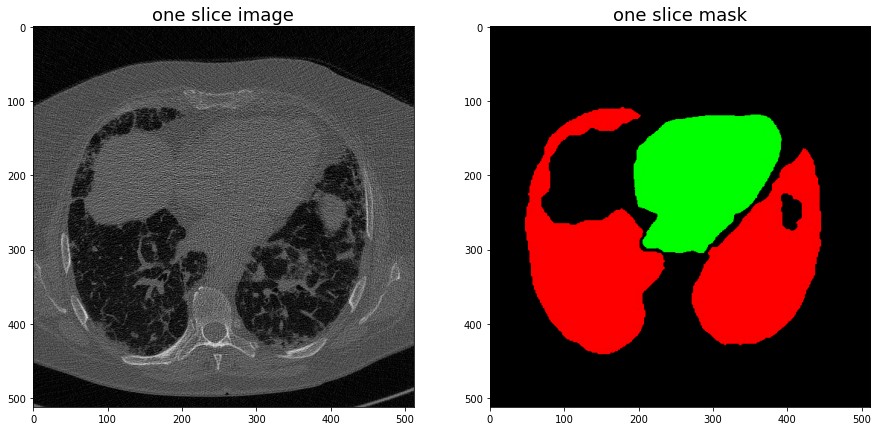

In [ ]:
slice_ = 120  # chose slice
img_name = imgs[slice_]
mask_name = masks[slice_]
one_slice_img, one_slice_mask = get_one_slice_data(img_name, mask_name)

data_to_plot = [one_slice_img, one_slice_mask]  
labels = ['one slice image', 'one slice mask'] 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
                                  
for i, ax in enumerate(axes):
    ax.imshow(data_to_plot[i], cmap=cmaps[i])
    ax.set_title(labels[i], fontdict={"fontsize": 18})

fig.savefig("data_example1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')

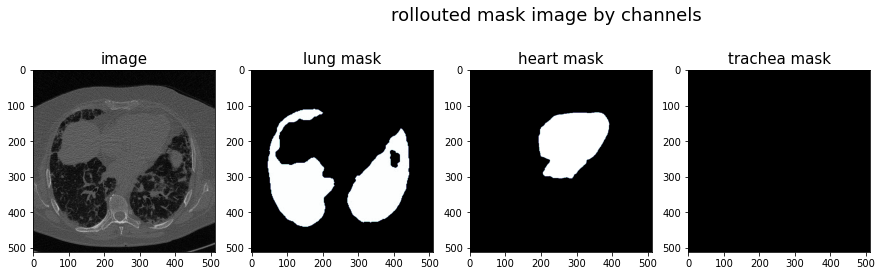

In [ ]:
data_to_plot = [one_slice_img, 
                one_slice_mask[:,:,0],
                one_slice_mask[:,:,1],
                one_slice_mask[:,:,2]
                ]
labels = ['image', 'lung mask', 'heart mask', 'trachea mask']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 8))
                                  
for i, ax in enumerate(axes):
    ax.imshow(data_to_plot[i], cmap=cmaps[i])
    ax.set_title(labels[i], fontdict={"fontsize": 15})

plt.suptitle("rollouted mask image by channels", y=0.77, x=0.60, fontsize=18)
fig.savefig("data_example2.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')

image with overlapping masks

In [ ]:
# Save image in original resolution
# helpful link - https://stackoverflow.com/questions/34768717/matplotlib-unable-to-save-image-in-same-resolution-as-original-image

def get_overlaid_masks_on_image(
                one_slice_image: np.ndarray,
                one_slice_mask: np.ndarray, 
                w: float = 512,
                h: float = 512, 
                dpi: float = 100,
                write: bool = False,
                path_to_save: str = '/content/',
                name_to_save: str = 'img_name'):
    """overlap masks on image and save this as a new image."""

    path_to_save_ = os.path.join(path_to_save, name_to_save)
    lung, heart, trachea = [one_slice_mask[:, :, i] for i in range(3)]
    figsize = (w / dpi), (h / dpi)
    fig = plt.figure(figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])

    # image
    plt.imshow(one_slice_image, cmap="bone")

    # Overlaying segmentation masks
    plt.imshow(np.ma.masked_where(lung == False, lung),
            cmap='cool_r', alpha=0.3)
    plt.imshow(np.ma.masked_where(heart == False, heart),
            cmap='rainbow', alpha=0.3)
    plt.imshow(np.ma.masked_where(trachea == False, trachea),
               cmap='autumn', alpha=0.3) #cool_r - blue

    plt.axis('off')
    fig.savefig(f"{path_to_save_}.png", bbox_inches='tight', 
                pad_inches=0.0, dpi=dpi, format="png")
    
    #plt.savefig(f"{path_to_save_}.svg", bbox_inches='tight',
    #            pad_inches=0.0, dpi=dpi, format="svg")
    if write:
        plt.close()
    else:
        plt.show()

In [ ]:
NUM_SLICE = len(imgs)
PATH_TO_SAVE = id_

if not os.path.exists(PATH_TO_SAVE):
    os.mkdir(PATH_TO_SAVE)
    print(f"Folder {PATH_TO_SAVE} created.")

Folder ID00400637202305055099402 created.


In [ ]:
%%time
for slice_ in range(NUM_SLICE):
    img_name = imgs[slice_]
    mask_name = masks[slice_]
    one_slice_img, one_slice_mask = get_one_slice_data(img_name, mask_name)
    get_overlaid_masks_on_image(one_slice_img,
                            one_slice_mask,
                            write=True, 
                            path_to_save=PATH_TO_SAVE,
                            name_to_save=str(slice_)
                            )


CPU times: user 1min 25s, sys: 35.1 s, total: 2min
Wall time: 2min


In [ ]:
def create_video(path_to_imgs: str, video_name: str, framerate: int):
    """
    Create video from images.
    Params:
        path_to_imgs: path to dir with images.
        video_name: name for saving video.
        framerate: num frames per sec in video.
    """
    img_names = sorted(os.listdir(path_to_imgs), key=lambda x: int(x[:-4]))  # img_name must be numbers
    img_path = os.path.join(path_to_imgs, img_names[0])
    frame_width, frame_height, _ = cv2.imread(img_path).shape
    fourc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_name + ".mp4", 
                            fourc, 
                            framerate, 
                            (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        video.write(image)
            
    cv2.destroyAllWindows()
    video.release()

In [ ]:
%%time
create_video(path_to_imgs=PATH_TO_SAVE, video_name=id_, framerate=10)

CPU times: user 3.05 s, sys: 132 ms, total: 3.18 s
Wall time: 3.21 s


In [ ]:
# to play in google colab had to recode
!ffmpeg -i '/content/ID00400637202305055099402.mp4' -strict -2 'transcoded_video.mp4'

In [ ]:
video = io.open('/content/transcoded_video.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))